# Redes neuronales para clasificación de secuencias

Ahora veremos cómo podemos, a partir de una secuencia de datos, inferir a qué clase pertenecen. Para esta tarea vamos a usar nuevamente un RNN del tipo LSTM, pero esta vez con una sola salida.

La tarea que vamos a tener es la siguiente: a partir de menus que proporcionan los restaurantes, clasificar estos restaurantes en una categoría de precios. Vamos a tener cuatro categorías de prcios, donde 1 son los restaurantes más baratos, mientras que 4 son los más caros. 

## Cargar las bibliotecas necesarias

In [111]:
import json

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Activation, SpatialDropout1D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Preparar los datos

Como hemos visto en el ejercicio pasado, debemos cargar los datos. Además será necesario ver cómo su organización 

In [113]:
train_set = list()
dev_set = list()

with open("Data/trainset.json") as F:
    for line in F:
        train_set.append(json.loads(line))
with open("Data/devset.json") as F:
    for line in F:
        dev_set.append(json.loads(line))

print(train_set[1])
print(len(train_set))
print(len(dev_set))

{'rating': '$$', 'name': 'Bin38', 'type': 'american (new)', 'location': 'sf', 'menu': ['bin frittata artisan ham swiss cheese potatoes mixed greens', 'sweet corn fritters wildflower honey whipped butter', 'strawberry eclairs white chocolate mousse hazelnuts', 'grilled cheese on whole wheat fontina smoked mozzarella oven roasted tomatoes arugula basil mayo', 'beef brisket panini fontina oven roasted tomatoes arugula horseradish sauce items marked with served before pm', 'hot beef brisket sandwich creamy horseradish sauce slaw french fries', 'roasted wild mushroom panini fromage blanc gypsy peppers creamy smoked pepper dip', 'house made chicken sausage grilled summer squash basil pesto', 'bacon wrapped sea scallops summer melon herb salad balsamic', 'american artisan cheeses small house made crackers fruit and condiments items marked with served before pm', 'warm marinated olives items marked with served before pm', 'wild mushroom gypsy pepper panini fromage blanc creamy smoked pepper di

In [114]:
train_ratings = list()
train_menus = list()

dev_ratings = list()
dev_menus = list()

dictionary = list()
rating_labels = list()

for restaurant in train_set:
    menu = " . ".join(restaurant["menu"]).split()
    train_menus.append(menu)
    train_ratings.append(len(restaurant["rating"])-1)
    dictionary += menu

for restaurant in dev_set:
    menu = " . ".join(restaurant["menu"]).split()
    dev_menus.append(menu)
    dev_ratings.append(len(restaurant["rating"])-1)

dictionary = list(set(dictionary))
print(train_menus[0][:30])
print(train_ratings[0])
print(len(dictionary))


['squid', 'tofu', 'lunch', 'cooked', 'squid', 'tofu', 'vegetables', 'with', 'seasoned', 'soy', 'sauce', '.', 'edamame', 'broiled', 'green', 'soybeans', '.', 'hotate', 'scallop', '.', 'oyako', 'don', 'dinner', 'chicken', 'vegetables', 'and', 'egg', 'cooked', 'with', 'sweet']
1
44090


Ahora nuevamente convertiremos todas las palabras en enteros y los rankings a varables categóricas

In [115]:
word_to_index = {"PAD":0,"OOV":1, "BOS":2, "EOS":3}
for word in dictionary:
    word_to_index[word] = len(word_to_index)

def sent_to_int(sent):
    int_sent = list()
    for word in sent:
        if word in word_to_indx.keys():
            int_sent.append(word_to_index[word])
        else:
            int_sent.append(word_to_index["OOV"])
    return int_sent

train_X, dev_X, train_Y, dev_Y = list(), list(), list(), list()

for lineX, lineY in zip(train_menus, train_ratings):
    train_X.append(sent_to_int(lineX))
    train_Y.append(to_categorical(lineY, num_classes=4))

for lineX, lineY in zip(dev_menus, dev_ratings):
    dev_X.append(sent_to_int(lineX))
    dev_Y.append(to_categorical(lineY, num_classes=4))
    
train_Y = np.asarray(train_Y)
dev_Y = np.asarray(dev_Y)

print(train_X[1])
print(train_Y[1])

[39643, 11045, 39143, 3667, 13498, 14402, 6290, 3172, 25949, 41482, 19469, 35181, 27017, 26415, 3732, 16829, 15711, 41482, 4927, 16116, 42251, 21760, 27702, 3162, 41482, 10698, 14402, 33541, 20159, 8604, 41010, 10676, 39612, 16557, 41972, 5361, 6211, 21217, 26980, 41482, 12204, 19211, 9223, 41010, 16557, 41972, 5361, 6211, 7607, 42801, 28263, 8897, 13376, 27654, 15140, 25538, 41482, 27112, 12204, 19211, 20554, 42810, 7607, 42801, 33079, 8304, 27800, 41482, 41972, 14184, 6862, 9223, 29849, 23071, 39175, 6910, 42810, 10676, 17266, 10216, 41482, 9045, 25128, 28232, 29197, 10698, 20595, 1907, 21217, 15872, 41482, 22640, 38693, 41671, 18656, 20595, 11656, 33676, 26218, 27267, 41482, 32244, 39143, 8144, 2434, 9045, 25128, 33525, 25678, 17578, 1132, 28263, 8897, 13376, 27654, 15140, 25538, 41482, 42511, 43287, 34584, 28263, 8897, 13376, 27654, 15140, 25538, 41482, 14184, 6862, 39175, 17266, 9223, 29849, 23071, 42810, 10676, 17266, 10216, 28263, 8897, 13376, 27654, 15140, 25538, 41482, 10698, 

Limitaremos el tamaño de las entradas a 200 palabras, dada la gran variabilidad de los menus encontrados.

In [116]:
MAX_LENGTH = 300
train_X = pad_sequences(maxlen=MAX_LENGTH, sequences=train_X, padding="post")
dev_X = pad_sequences(maxlen=MAX_LENGTH, sequences=dev_X, padding="post")

print(train_X[1])


[21217 15872 41482 22640 38693 41671 18656 20595 11656 33676 26218 27267
 41482 32244 39143  8144  2434  9045 25128 33525 25678 17578  1132 28263
  8897 13376 27654 15140 25538 41482 42511 43287 34584 28263  8897 13376
 27654 15140 25538 41482 14184  6862 39175 17266  9223 29849 23071 42810
 10676 17266 10216 28263  8897 13376 27654 15140 25538 41482 10698 20595
  1907 23998 14402 21217 15872  1867 41482 40028 25654 29427 37529 24395
 41482 11894  6861 41972 15218 13498  9223 20159 22945 22598  5707 41482
  9045 25128  5119 29197 37403 33005 26218 20159 22945 22598 41482   249
 15218 26506  1982 28228 22462 28395 42801 41482 14824  5361   884 23998
 14402  6211 21992 23364 25119 41482 39643  3172 39692 28263  8897 13376
 27654 15140 25538 41482 19861 17103 26218 27400 12401  8192 33750  1155
 41153 23071 25119 28263  8897 13376 27654 15140 25538 41482 32244 39143
  8144 37020  9045 25128 33525 25678 17578  1132 28263  8897 13376 27654
 15140 25538 41482  9102 20496 21760 15412 16829 31

## Definir el modelo y entrenar con LSTM

Ahora definimos nuestra red. Veamamos ahora que configuraremos algunos hyperparámetros adicionales en el optimizador, ademas de usar Adam esta vez.

In [117]:
EMBEDDING_SIZE = 50
EPOCHS = 50
BATCH_SIZE = 32
HIDDEN_LAYER_SIZE = 64
DROPOUT = 0.2

model = Sequential()
model.add(Embedding(len(word_to_index), EMBEDDING_SIZE, input_length=MAX_LENGTH))
#model.add(SpatialDropout1D(Dropout(DROPOUT)))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=DROPOUT, recurrent_dropout=DROPOUT))
model.add(Dense(4))
model.add(Activation("sigmoid"))

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=["accuracy",])

Y la entrenamos. Dado que el entrenamiento será largo, vamos a utilizar una opción llamada parada temprana o early stopping. Básicamente lo que hace es parar el entrenamiento cuando no se logre mejorar el costo en un cierto periodo de épocas. Ese periodo de épocas es llamado paciencia (patience).

In [118]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
history = model.fit(train_X, train_Y, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(dev_X, dev_Y), callbacks=[es])

Train on 4860 samples, validate on 607 samples
Epoch 1/50
  32/4860 [..............................] - ETA: 14:26 - loss: 1.3859 - acc: 0.1562

KeyboardInterrupt: 

## Resultados

Ahora veamos el comportamiento del entrenamiento a travéz de las épocas.

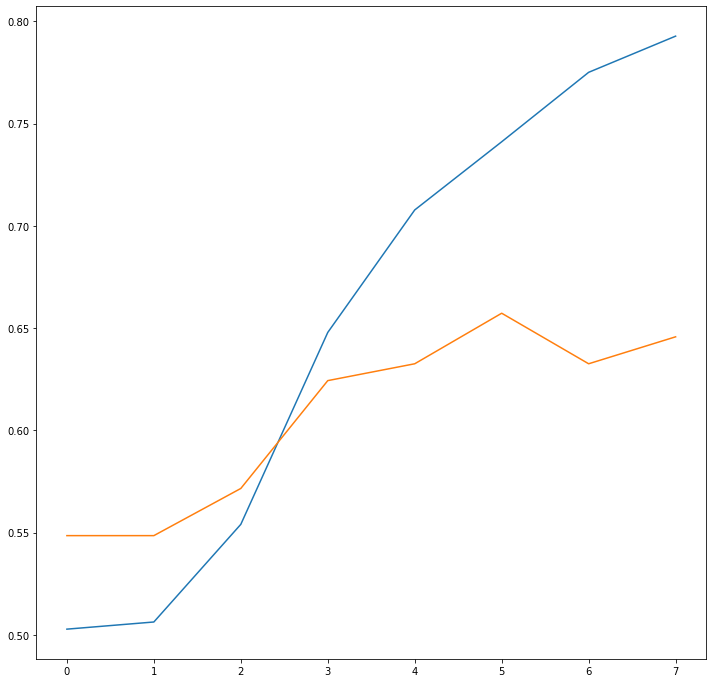

In [105]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

Y guardamos el modelo

In [ ]:
model.save("Models/restaurant_classification.h5")

## Ejercicio

Hemos visto cómo usar un LSTM para entrenar un modelo que nos permite clasificar un texto. Sin embargo, el set de datos con el que contamos incluye información complementaria: cómo tipo de restaurante y localización del mismo. Es hora de integrar estos datos para mejorar el rendimiento del modelo. 

* ¿Cuál sería la mejor forma de integrar estos datos al modelo?
* Implemente una solución y demuestre que su modelo mejora al LSTM simple.
* ¿Tiene alguna otra idea de cómo mejorar el rendimiento del modelo?